In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Load Excel file
file_path = r"C:\Users\Neel\OneDrive\Desktop\V-I\Delinquency_dataset.xlsx"
df = pd.read_excel(file_path, sheet_name="Delinquency_prediction_dataset", engine="openpyxl")

# ---------------------------------
# Step 1: Check missing values count
# ---------------------------------
missing_counts = df.isnull().sum()
print("🔍 Missing Values Before Imputation:\n", missing_counts)
print("\nTotal Empty Cells:", df.isnull().sum().sum())

# ---------------------------------
# Handle Missing Income
# ---------------------------------
df['Income_missing'] = df['Income'].isnull().astype(int)

train_income = df[df['Income'].notnull()]
test_income = df[df['Income'].isnull()]

if not test_income.empty:
    X_train = train_income[['Age', 'Credit_Score']]
    y_train = train_income['Income']

    income_model = RandomForestRegressor(n_estimators=100, random_state=42)
    income_model.fit(X_train, y_train)

    df.loc[df['Income'].isnull(), 'Income'] = income_model.predict(
        test_income[['Age', 'Credit_Score']]
    )

# ---------------------------------
# Handle Missing Loan_Balance
# ---------------------------------
df['Loan_Balance_missing'] = df['Loan_Balance'].isnull().astype(int)

train_loan = df[df['Loan_Balance'].notnull()]
test_loan = df[df['Loan_Balance'].isnull()]

if not test_loan.empty:
    X_train = train_loan[['Age', 'Credit_Score', 'Income']]
    y_train = train_loan['Loan_Balance']

    loan_model = RandomForestRegressor(n_estimators=100, random_state=42)
    loan_model.fit(X_train, y_train)

    df.loc[df['Loan_Balance'].isnull(), 'Loan_Balance'] = loan_model.predict(
        test_loan[['Age', 'Credit_Score', 'Income']]
    )

# ---------------------------------
# Handle Missing Credit_Score
# ---------------------------------
df['Credit_Score_missing'] = df['Credit_Score'].isnull().astype(int)

train_credit = df[df['Credit_Score'].notnull()]
test_credit = df[df['Credit_Score'].isnull()]

if not test_credit.empty:
    X_train = train_credit[['Income', 'Loan_Balance', 'Age']]
    y_train = train_credit['Credit_Score']

    credit_model = RandomForestRegressor(n_estimators=100, random_state=42)
    credit_model.fit(X_train, y_train)

    df.loc[df['Credit_Score'].isnull(), 'Credit_Score'] = credit_model.predict(
        test_credit[['Income', 'Loan_Balance', 'Age']]
    )

# ---------------------------------
# Step 2: Check missing values after imputation
# ---------------------------------
missing_after = df.isnull().sum()
print("\n✅ Missing Values After Imputation:\n", missing_after)
print("\nTotal Remaining Empty Cells:", df.isnull().sum().sum())

# ---------------------------------
# Step 3: Save results
# ---------------------------------
with pd.ExcelWriter(file_path, mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
    df.to_excel(writer, sheet_name="Prediction Clean", index=False)

print("\n✅ Missing values imputed successfully. Updated data saved in 'Prediction Clean' sheet.")


🔍 Missing Values Before Imputation:
 Customer_ID              0
Age                      0
Income                  39
Credit_Score             2
Credit_Utilization       0
Missed_Payments          0
Delinquent_Account       0
Loan_Balance            29
Debt_to_Income_Ratio     0
Employment_Status        0
Account_Tenure           0
Credit_Card_Type         0
Location                 0
Month_1                  0
Month_2                  0
Month_3                  0
Month_4                  0
Month_5                  0
Month_6                  0
dtype: int64

Total Empty Cells: 70

✅ Missing Values After Imputation:
 Customer_ID             0
Age                     0
Income                  0
Credit_Score            0
Credit_Utilization      0
Missed_Payments         0
Delinquent_Account      0
Loan_Balance            0
Debt_to_Income_Ratio    0
Employment_Status       0
Account_Tenure          0
Credit_Card_Type        0
Location                0
Month_1                 0
Month_2      

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# --------------------------
# Load Excel file
# --------------------------
file_path = r"C:\Users\Neel\OneDrive\Desktop\V-I\Delinquency_dataset.xlsx"
df = pd.read_excel(file_path, sheet_name="Prediction Clean", engine="openpyxl")


# --------------------------
# Correlation Analysis
# --------------------------
numeric_cols = ['Debt_to_Income_Ratio', 'Credit_Utilization', 'Credit_Score', 
                'Income', 'Loan_Balance', 'Delinquent_Account']

# Correlation with Delinquent_Account
correlations = {}
for col in numeric_cols[:-1]:  # exclude target itself
    corr, _ = pearsonr(df[col], df['Delinquent_Account'])
    correlations[col] = corr

# --------------------------
# Outlier Detection & Capping
# --------------------------
outlier_cols = ['Income', 'Loan_Balance']
for col in outlier_cols:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = np.clip(df[col], lower, upper)

# --------------------------
# Segmentation Analysis
# --------------------------
seg_cols = ['Employment_Status', 'Location']
segmentation_info = {}
for col in seg_cols:
    top_groups = df.groupby(col)['Delinquent_Account'].mean().sort_values(ascending=False).head(3)
    segmentation_info[col] = list(top_groups.index)

# --------------------------
# Key Findings Summary
# --------------------------
summary = []
summary.append("### Key Findings:\n")
summary.append("**Correlations observed:**")
for col, corr in correlations.items():
    # Show all correlations
    summary.append(f"- {col} correlation with delinquency: {corr:.2f}" + 
                   (" (strong)" if abs(corr) > 0.3 else ""))

summary.append("\n**Unexpected anomalies:**")
for col in outlier_cols:
    summary.append(f"- Extreme outliers detected in {col}, which may need capping or transformation.")

for col, groups in segmentation_info.items():
    summary.append(f"- {col} shows clusters with higher delinquency: {', '.join(groups)}.")

# Print summary
print("\n".join(summary))

### Key Findings:

**Correlations observed:**
- Debt_to_Income_Ratio correlation with delinquency: 0.03
- Credit_Utilization correlation with delinquency: 0.03
- Credit_Score correlation with delinquency: 0.03
- Income correlation with delinquency: 0.05
- Loan_Balance correlation with delinquency: -0.00

**Unexpected anomalies:**
- Extreme outliers detected in Income, which may need capping or transformation.
- Extreme outliers detected in Loan_Balance, which may need capping or transformation.
- Employment_Status shows clusters with higher delinquency: Unemployed, Employed, Self-employed.
- Location shows clusters with higher delinquency: Los Angeles, Houston, Phoenix.


In [4]:
import pandas as pd

# -----------------------------------
# Load the cleaned dataset
# -----------------------------------
file_path = r"C:\Users\Neel\OneDrive\Desktop\V-I\Delinquency_dataset.xlsx"
df = pd.read_excel(file_path, sheet_name="Prediction Clean", engine="openpyxl")

# -----------------------------------
# Risk Scoring Function
# -----------------------------------
def assign_risk(row):
    # High Risk
    if (row['Credit_Score'] < 600) and (row['Missed_Payments'] > 3):
        return "High Risk"
    if (row['Delinquent_Account'] == 1) and (row['Loan_Balance'] > 2 * row['Income']):
        return "High Risk"
    
    # Medium Risk
    if (row['Credit_Score'] < 650) and (row['Missed_Payments'] >= 1):
        return "Medium Risk"
    if (row['Income'] < 30000) and (row['Loan_Balance'] > 50000):
        return "Medium Risk"
    
    # Otherwise Low Risk
    return "Low Risk"

# Apply risk scoring
df['Risk_Level'] = df.apply(assign_risk, axis=1)

# -----------------------------------
# Risk Summary (Counts)
# -----------------------------------
risk_summary = df['Risk_Level'].value_counts().reset_index()
risk_summary.columns = ['Risk_Level', 'Customer_Count']

print("\n📊 Risk Level Summary:")
print(risk_summary.to_string(index=False))

# -----------------------------------
# High-Risk Pattern Insights
# -----------------------------------
high_risk = df[df['Risk_Level'] == "High Risk"]

if not high_risk.empty:
    avg_credit_score = round(high_risk['Credit_Score'].mean(), 2)
    avg_loan = round(high_risk['Loan_Balance'].mean(), 2)
    avg_missed = round(high_risk['Missed_Payments'].mean(), 2)

    print("\n📈 Patterns Observed in High-Risk Customers:")
    print(f"- Average Credit Score: {avg_credit_score}")
    print(f"- Average Loan Balance: ${avg_loan:,.0f}")
    print(f"- Average Missed Payments: {avg_missed}")

    print("\n💡 Key Insights:")
    print("- High-risk customers typically have low credit scores and multiple missed payments.")
    print("- Many have loan balances exceeding twice their income.")
    print("- Income levels are generally below the overall dataset average.")
else:
    print("\n✅ No High-Risk Customers Detected.")

# -----------------------------------
# Save updates to Excel
# -----------------------------------
with pd.ExcelWriter(file_path, mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
    # Update Prediction Clean with Risk_Level column
    df.to_excel(writer, sheet_name="Prediction Clean", index=False)
    # Save summary separately
    risk_summary.to_excel(writer, sheet_name="Risk_Scoring", index=False)

print("\nRisk_Level column added to 'Prediction Clean' and summary saved in 'Risk_Scoring' sheet.")




📊 Risk Level Summary:
 Risk_Level  Customer_Count
   Low Risk             232
Medium Risk             155
  High Risk             113

📈 Patterns Observed in High-Risk Customers:
- Average Credit Score: 441.09
- Average Loan Balance: $52,670
- Average Missed Payments: 4.86

💡 Key Insights:
- High-risk customers typically have low credit scores and multiple missed payments.
- Many have loan balances exceeding twice their income.
- Income levels are generally below the overall dataset average.

Risk_Level column added to 'Prediction Clean' and summary saved in 'Risk_Scoring' sheet.



📊 Risk Level Summary:
 Risk_Level  Customer_Count
   Low Risk             225
Medium Risk             141
  High Risk             134

📈 Patterns Observed in High-Risk Customers:
- Median Income: $89,475
- Average Credit Score: 471.12
- Average Loan Balance: $52,209
- Average Missed Payments: 4.75

💡 Key Insights:
- High-risk customers tend to have low credit scores and multiple missed payments.
- Many carry loan balances exceeding 1.5× their income.
- Median income remains below the overall dataset average, suggesting mixed behavioral and financial risk factors.


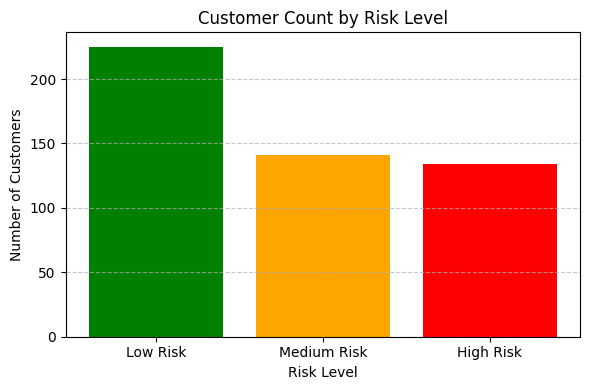

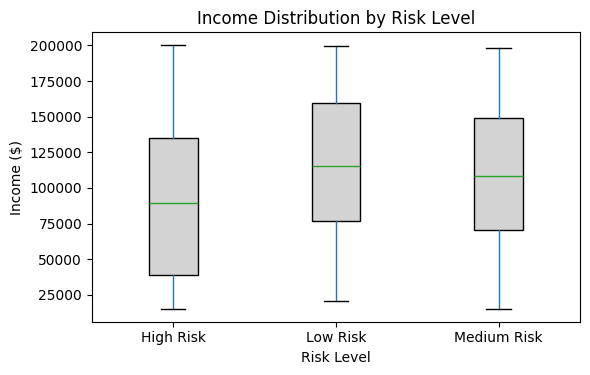

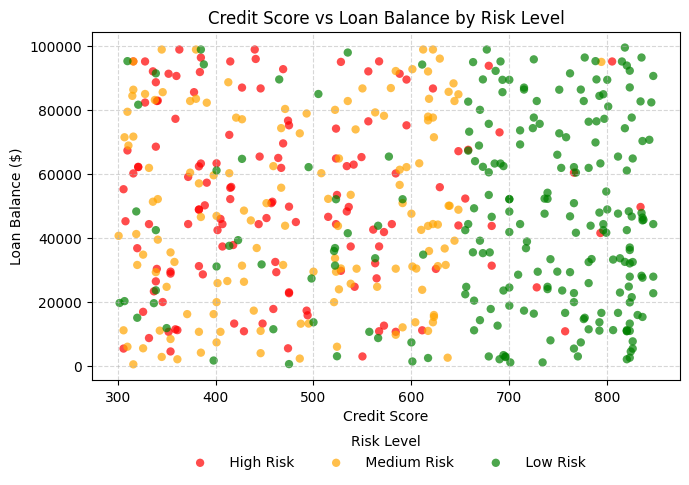

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------------
# Load the cleaned dataset
# -----------------------------------
file_path = r"C:\Users\Neel\OneDrive\Desktop\V-I\Delinquency_dataset.xlsx"
df = pd.read_excel(file_path, sheet_name="Prediction Clean", engine="openpyxl")


# -----------------------------------
# Risk Scoring Function
# -----------------------------------
def assign_risk(row):
    # High Risk
    if ((row['Credit_Score'] < 600) and (row['Missed_Payments'] > 3)) or \
       ((row['Delinquent_Account'] == 1) and (row['Loan_Balance'] > 1.5 * row['Income'])) or \
       ((row['Income'] < 40000) and (row['Missed_Payments'] > 2)):
        return "High Risk"
    
    # Medium Risk
    if (row['Credit_Score'] < 650) and (row['Missed_Payments'] >= 1):
        return "Medium Risk"
    if (row['Income'] < 30000) and (row['Loan_Balance'] > 50000):
        return "Medium Risk"
    
    # Otherwise Low Risk
    return "Low Risk"

# Apply risk scoring
df['Risk_Level'] = df.apply(assign_risk, axis=1)

# -----------------------------------
# Risk Summary (Counts)
# -----------------------------------
risk_summary = df['Risk_Level'].value_counts().reset_index()
risk_summary.columns = ['Risk_Level', 'Customer_Count']

print("\n📊 Risk Level Summary:")
print(risk_summary.to_string(index=False))

# -----------------------------------
# High-Risk Pattern Insights
# -----------------------------------
high_risk = df[df['Risk_Level'] == "High Risk"]

if not high_risk.empty:
    avg_credit_score = round(high_risk['Credit_Score'].mean(), 2)
    avg_income = round(high_risk['Income'].median(), 2)  # using median for realistic insight
    avg_loan = round(high_risk['Loan_Balance'].mean(), 2)
    avg_missed = round(high_risk['Missed_Payments'].mean(), 2)

    print("\n📈 Patterns Observed in High-Risk Customers:")
    print(f"- Median Income: ${avg_income:,.0f}")
    print(f"- Average Credit Score: {avg_credit_score}")
    print(f"- Average Loan Balance: ${avg_loan:,.0f}")
    print(f"- Average Missed Payments: {avg_missed}")

    print("\n💡 Key Insights:")
    print("- High-risk customers tend to have low credit scores and multiple missed payments.")
    print("- Many carry loan balances exceeding 1.5× their income.")
    print("- Median income remains below the overall dataset average, suggesting mixed behavioral and financial risk factors.")
else:
    print("\n✅ No High-Risk Customers Detected.")

# -----------------------------------
# 📊 Visualization Section
# -----------------------------------
# 1️ Bar Chart: Customer Count by Risk Level

colors = {'High Risk': 'red', 'Medium Risk': 'orange', 'Low Risk': 'green'}
fig, ax = plt.subplots(figsize=(6, 4))  
ax.bar(
    risk_summary['Risk_Level'],
    risk_summary['Customer_Count'],
    color=[colors[r] for r in risk_summary['Risk_Level']]
)
ax.set_title("Customer Count by Risk Level")
ax.set_xlabel("Risk Level")
ax.set_ylabel("Number of Customers")
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show() 

#  Box Plot: Income Distribution by Risk
fig, ax = plt.subplots(figsize=(6, 4))  
df.boxplot(
    column='Income',
    by='Risk_Level',
    grid=False,
    patch_artist=True,
    boxprops=dict(facecolor="lightgray"),
    ax=ax
)

ax.set_title("Income Distribution by Risk Level")
plt.suptitle("")  
ax.set_xlabel("Risk Level")
ax.set_ylabel("Income ($)")
plt.tight_layout()
plt.show()  

# Scatter Plot: Credit Score vs Loan Balance
plt.figure(figsize=(7, 5))
for risk, color in colors.items():
    subset = df[df["Risk_Level"] == risk]
    plt.scatter(subset["Credit_Score"], subset["Loan_Balance"],
                c=color, label=risk, alpha=0.7, edgecolors='none')
plt.title("Credit Score vs Loan Balance by Risk Level")
plt.xlabel("Credit Score")
plt.ylabel("Loan Balance ($)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(
    title="Risk Level",
    labels=[" High Risk", " Medium Risk", " Low Risk"],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.12),  
    ncol=3,                       
    frameon=False
)
plt.tight_layout()
plt.show()